# Libraries

In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import warnings

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import string
import nltk
nltk.download('stopwords')
import shutil

import seaborn as sns
import matplotlib.pylab as plt

from datetime import datetime, timedelta
from tqdm import tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clairephibbs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#os.chdir('C:\\Users\\halle.davis\\Downloads\\') ## Halle's work folder path
#os.chdir('/Users/halledavis/Downloads/') ## Halle's personal folder path
os.chdir('/users/clairephibbs/Desktop/Capstone') ## Claire's folder path
#os.chdir('/Users/summerpurschke/Desktop/ADS/Capstone') ## Summer's folder path

In [3]:
accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')

# inspections = pd.read_csv('Inspections.txt', sep= '|', encoding = 'latin-1')
# mines = pd.read_csv('Mines.txt', sep= '|', encoding = 'latin-1')

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4217344869.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4217344869.py:2: DtypeWarning: Columns (25,34,36,37,43,45,46,55,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')


# Data Cleaning

## Assessing Duplicates

In [119]:
violations.duplicated().sum()

0

In [120]:
accidents.duplicated().sum()

0

INSIGHT: No duplicate values in the violations and accidents dataframes.

## Assessing Nulls

### Violation Data

In [4]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = violations.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')

INSPECTION_END_DT                 7665
CONTROLLER_ID                   192131
CONTROLLER_NAME                 192131
VIOLATOR_ID                        120
VIOLATOR_NAME                      135
MINE_TYPE                           21
CONTRACTOR_ID                  2622477
SIG_SUB                          45093
SECTION_OF_ACT                 2796797
PART_SECTION                     30731
SECTION_OF_ACT_2               2811540
ORIG_TERM_DUE_DT                677782
ORIG_TERM_DUE_TIME              677782
LATEST_TERM_DUE_DT               94312
LATEST_TERM_DUE_TIME             94312
TERMINATION_DT                   18626
TERMINATION_TIME                 18626
VACATE_DT                      2812687
VACATE_TIME                    2812687
INITIAL_VIOL_NO                2737136
REPLACED_BY_ORDER_NO           2795513
LIKELIHOOD                       46331
INJ_ILLNESS                      46314
NEGLIGENCE                       46297
WRITTEN_NOTICE                 1440981
ENFORCEMENT_AREA         

In [5]:
# Fill in missing values
violations  = violations.replace('?', np.nan)

### Accident Data

In [6]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = accidents.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')

CONTROLLER_ID           719
CONTROLLER_NAME         719
OPERATOR_ID             719
OPERATOR_NAME           719
CONTRACTOR_ID        229611
ACCIDENT_TIME             1
EQUIP_MODEL_NO       151664
SHIFT_BEGIN_TIME        990
NO_INJURIES              24
TOT_EXPER             42602
MINE_EXPER            39673
JOB_EXPER             38873
INJ_BODY_PART            25
SCHEDULE_CHARGE       65023
DAYS_RESTRICT         59928
DAYS_LOST             44754
TRANS_TERM            34368
RETURN_TO_WORK_DT     41033
IMMED_NOTIFY             82
INVEST_BEGIN_DT      203054
NARRATIVE                91
CLOSED_DOC_NO        143124
COAL_METAL_IND          134
dtype: int64


In [7]:
# Fill in missing values
accidents  = accidents.replace('?', np.nan)

## Addressing Nulls

### INSPECTION_END_DT Missing Values: Remove INSPECTION_START_DT with year 2023

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/1807657532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_end_dt['INSPECTION_BEGIN_DT'] = pd.to_datetime(missing_end_dt['INSPECTION_BEGIN_DT'])
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/1807657532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_end_dt['Year'] = missing_end_dt['INSPECTION_BEGIN_DT'].dt.year


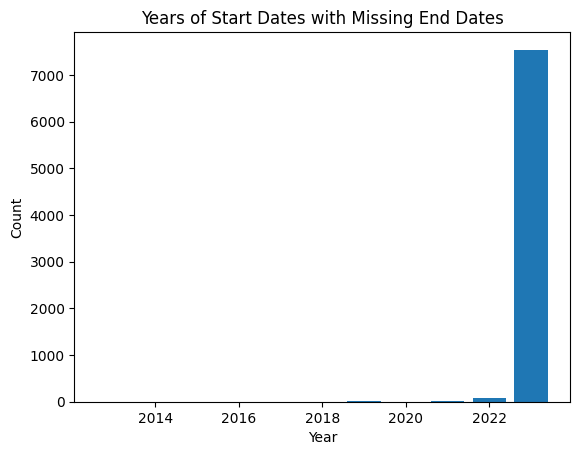

Year
2013       2
2014       1
2015       1
2018       2
2019       9
2020       3
2021      19
2022      86
2023    7542
Name: count, dtype: int64


In [28]:
# Visualizing the missing INSPECTION_END_DT's by year to test theory that majority of missings
# are coming from 2023 because inspection is still ongoing
missing_end_dt = violations[violations['INSPECTION_END_DT'].isnull()]

missing_end_dt['INSPECTION_BEGIN_DT'] = pd.to_datetime(missing_end_dt['INSPECTION_BEGIN_DT'])
missing_end_dt['Year'] = missing_end_dt['INSPECTION_BEGIN_DT'].dt.year
counts_by_year = missing_end_dt['Year'].value_counts().sort_index()

plt.bar(counts_by_year.index, counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Years of Start Dates with Missing End Dates')
plt.show()

print(counts_by_year)

Insight: We can see that majority of the inspections with missing end dates are inspections that started in 2023, which makes sense, given that those inspections are likely still ongoing. Would make sense to remove year 2023 of INSPECTION_BEGIN_DT from dataframe. We can also see in counts_by_year that there are some missing end dates for some pretty early years (i.e., 2013, 2014, 2015). Inspection may have been terminated or for some other reason the inspection was never completed, so would make sense to remove these as well.

In [29]:
# Copying dataframe for cleaned data
violations_cleaned = violations.copy()

# Converting 'INSPECTION_BEGIN_DT' to a datetime column 
violations_cleaned['INSPECTION_BEGIN_DT'] = pd.to_datetime(violations_cleaned['INSPECTION_BEGIN_DT'])

# Removing year 2023 from 'INSPECTION_LENGTH_DAYS' in violations df
violations_cleaned = violations_cleaned[violations_cleaned['INSPECTION_BEGIN_DT'].dt.year != 2023]

In [30]:
# confirming removal of 2023 from 'INSPECTION_BEGIN_DT' column
violations_cleaned['Year'] = violations_cleaned['INSPECTION_BEGIN_DT'].dt.year
violations_cleaned['Year'].value_counts().sort_index()

Year
2000    119520
2001    124165
2002    104371
2003    108413
2004    119971
2005    126672
2006    139122
2007    142686
2008    171914
2009    172486
2010    168977
2011    154499
2012    137519
2013    117695
2014    120269
2015    106260
2016     96407
2017    103712
2018     97202
2019     98521
2020     76781
2021     77177
2022     87185
Name: count, dtype: int64

In [31]:
# Dropping created year column 
violations_cleaned.drop(columns='Year', inplace=True)

# Removing 'INSPECTION_BEGIN_DT' from 2013-2022 with missing values 
violations_cleaned = violations_cleaned[violations_cleaned['INSPECTION_END_DT'].notna()]
violations_cleaned

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,DOCKET_NO,DOCKET_STATUS_CD,CONTESTED_IND,CONTESTED_DT,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,196.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,2282.0,02/05/2013,Paid,11/24/2015,NaN,NaN,N,NaN,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,460.0,02/05/2013,Paid,01/20/2016,NaN,NaN,N,NaN,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,207.0,02/05/2013,Paid,11/24/2015,NaN,NaN,N,NaN,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,127.0,02/05/2013,Paid,05/20/2014,NaN,NaN,N,NaN,14.0,6.0


NOTE: Dataset decreased from 2,812,757 rows to 2,771,401 rows after removing INSPECTION_BEGIN_DT 2023 and missing values in other years from 2013-2022. 

### Removing Columns and Rows with High Proportion of Missings

In [32]:
# Removing columns with 24% or more missing values 
violations_cleaned = violations_cleaned.drop(columns=['CONTRACTOR_ID', 'SECTION_OF_ACT', 'SECTION_OF_ACT_2',
                                             'ORIG_TERM_DUE_DT', 'ORIG_TERM_DUE_TIME', 'VACATE_DT',
                                             'VACATE_TIME', 'INITIAL_VIOL_NO', 'REPLACED_BY_ORDER_NO',
                                             'WRITTEN_NOTICE', 'ENFORCEMENT_AREA', 'PRIMARY_OR_MILL',
                                             'RIGHT_TO_CONF_DT', 'DOCKET_NO', 'DOCKET_STATUS_CD', 'CONTESTED_DT'])

violations_cleaned


,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


In [33]:
# Removing rows with more than 5 missing values since there isn't
# a great way to impute our data
violations_cleaned = violations_cleaned.dropna(thresh=violations_cleaned.shape[1] - 5)
violations_cleaned

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


NOTE: Dataset size decreased from 2,771,401 to 2,721,007.

## Data Filtering

### VIOLATOR_TYPE_CD: Filter to only operator mines

In [34]:
violations_cleaned = violations_cleaned.loc[violations_cleaned['VIOLATOR_TYPE_CD'] == 'Operator']
violations_cleaned

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0042611,Ann E Abramson,0051892,Aggregate Inc,Operator,5500013,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


NOTE: Dataset decreased from 2,771,401 to 2,537,310 after removing 'VIOLATOR_TYPE_CD' == 'Contractor'.

### Unnecessary Feature Removal (CONTROLLER_ID, CONTROLLER_NAME, ASMT_GENERATED_IND, LATEST_TERM_DUE_DT, LATEST_TERM_DUE_TIME, TERMINATION_DT, TERMINATION_TIME)

In [35]:
violations_cleaned = violations_cleaned.drop(columns=['CONTROLLER_ID', 'CONTROLLER_NAME', 'ASMT_GENERATED_IND', 'LATEST_TERM_DUE_DT',
                                                      'LATEST_TERM_DUE_TIME', 'TERMINATION_DT', 'TERMINATION_TIME'])
violations_cleaned

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,MINE_NAME,MINE_TYPE,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


In [36]:
violations_cleaned.isna().sum()

EVENT_NO                          0
INSPECTION_BEGIN_DT               0
INSPECTION_END_DT                 0
VIOLATION_NO                      0
VIOLATOR_ID                       4
VIOLATOR_NAME                     4
VIOLATOR_TYPE_CD                  0
MINE_ID                           0
MINE_NAME                         0
MINE_TYPE                        11
COAL_METAL_IND                    0
VIOLATION_ISSUE_DT                0
VIOLATION_OCCUR_DT                0
CAL_YR                            0
CAL_QTR                           0
FISCAL_YR                         0
FISCAL_QTR                        0
VIOLATION_ISSUE_TIME              0
SIG_SUB                          44
PART_SECTION                   9298
SECTION_OF_ACT_1                  0
CIT_ORD_SAFE                      0
TERMINATION_TYPE                  0
LIKELIHOOD                      351
INJ_ILLNESS                     332
NO_AFFECTED                       0
NEGLIGENCE                      331
SPECIAL_ASSESS              

### Outlier Removal

In [38]:
numeric_vars = ['NO_AFFECTED', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID', 'VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT']

# Set a threshold for Z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold based on your data and requirements

# Create a copy of the original DataFrame to store the outliers removed data
outliers_removed = violations_cleaned.copy()

# Loop through each column and remove outliers based on Z-scores
for column_name in numeric_vars:
    # Calculate the Z-scores for the current column
    z_scores = np.abs((violations_cleaned[column_name] - violations_cleaned[column_name].mean()) / violations_cleaned[column_name].std())

    # Filter the DataFrame to keep only the rows where the Z-score is less than the threshold for the current column
    outliers_removed = outliers_removed[z_scores < z_score_threshold]

outliers_removed

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[z_scores < z_score_threshold]
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[z_scores < z_score_threshold]
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[z_scores < z_score_threshold]
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_removed = outliers_removed[z_scores < z_score_threshold]
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_11319/4034725783.py:15: UserWarni

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,MINE_NAME,MINE_TYPE,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812752,6644004,2012-12-10,12/13/2012,8727304,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,2282.0,2282.0,2282.0,02/05/2013,Paid,11/24/2015,N,14.0,5.0
2812753,6644004,2012-12-10,12/13/2012,8727305,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,460.0,460.0,460.0,02/05/2013,Paid,01/20/2016,N,14.0,5.0
2812754,6644004,2012-12-10,12/13/2012,8727306,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,207.0,207.0,207.0,02/05/2013,Paid,11/24/2015,N,14.0,6.0
2812755,6644004,2012-12-10,12/13/2012,8727307,0051892,Aggregate Inc,Operator,5500013,Caribbean Blue Stone,Surface,...,03/13/2013,127.0,127.0,127.0,02/05/2013,Paid,05/20/2014,N,14.0,6.0


NOTE: Removing outliers decreased the size of the dataset from 2,537,310 to 2,406,620.

In [ ]:
# Converts dataframe to a csv 
# outliers_removed.to_csv('violations_cleaned.csv', index=False)

# Feature Engineering

In [39]:
# CLAIRE GOING TO ADD IN HERE

# Merge Violations and Accidents

In [ ]:
# Get the column names of each dataframe
accidents_columns = set(accidents.columns)
violations_columns = set(violations.columns)

# Find the shared columns
shared_columns = set(accidents.columns) & set(violations.columns)

# Find the columns shared between accidents and violations dataframes
shared_accidents_violations = accidents_columns & violations_columns

# Print the columns shared between accidents and violations dataframes
print("\nColumns shared between accidents and violations dataframes:")
for column in shared_accidents_violations:
    print(column)

In [124]:
# # Extract unique values of 'MINE_ID' from inspections DataFrame
# inspections_mine_ids = inspections['MINE_ID'].unique()
# mines_mine_ids = mines['MINE_ID'].unique()
# accidents_mine_ids = accidents['MINE_ID'].unique()
# violations_mine_ids = violations['MINE_ID'].unique()

# # Combine the unique values from both DataFrames
# merged_mine_ids = pd.unique(inspections_mine_ids.tolist() + mines_mine_ids.tolist() + accidents_mine_ids.tolist() + violations_mine_ids.tolist())

# # Create a new DataFrame with the unique 'MINE_ID' values
# merged_df = pd.DataFrame({'MINE_ID': merged_mine_ids})

In [69]:
accidents = accidents.sort_values(by = 'ACCIDENT_DT')

Create a dataframe of accidents per mine

In [70]:
# Sort Values by Accident Date
accidents = accidents.sort_values(by = 'ACCIDENT_DT')

accidents_per_mine = accidents[['MINE_ID', 'ACCIDENT_DT']]

# Create a new column 'ACCIDENT' with unique accident numbers
accidents_per_mine.loc[:, 'ACCIDENT'] = 'ACCIDENT_' + (accidents_per_mine.groupby('MINE_ID').cumcount() + 1).astype(str)

# Pivot the DataFrame to reshape it with 'MINE_ID' as the index and 'ACCIDENT' as the columns
accidents_per_mine = accidents_per_mine.pivot(index='MINE_ID', columns='ACCIDENT', values='ACCIDENT_DT')

# Rename the columns with the desired format
accidents_per_mine.columns = ['ACCIDENT_' + str(i) for i in range(1, len(accidents_per_mine.columns) + 1)]

# Reset the index of the DataFrame
accidents_per_mine = accidents_per_mine.reset_index()

In [71]:
accidents_per_mine 

,MINE_ID,ACCIDENT_1,ACCIDENT_2,ACCIDENT_3,ACCIDENT_4,ACCIDENT_5,ACCIDENT_6,ACCIDENT_7,ACCIDENT_8,ACCIDENT_9,...,ACCIDENT_2443,ACCIDENT_2444,ACCIDENT_2445,ACCIDENT_2446,ACCIDENT_2447,ACCIDENT_2448,ACCIDENT_2449,ACCIDENT_2450,ACCIDENT_2451,ACCIDENT_2452
0,100003,01/08/2007,01/25/2008,08/11/2014,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100004,01/07/2008,06/19/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,01/13/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100008,01/06/2015,02/16/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100009,02/21/2023,07/12/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12950,5500002,01/03/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12951,5500005,01/09/2001,12/06/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12952,5500008,03/23/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12953,6600018,09/25/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


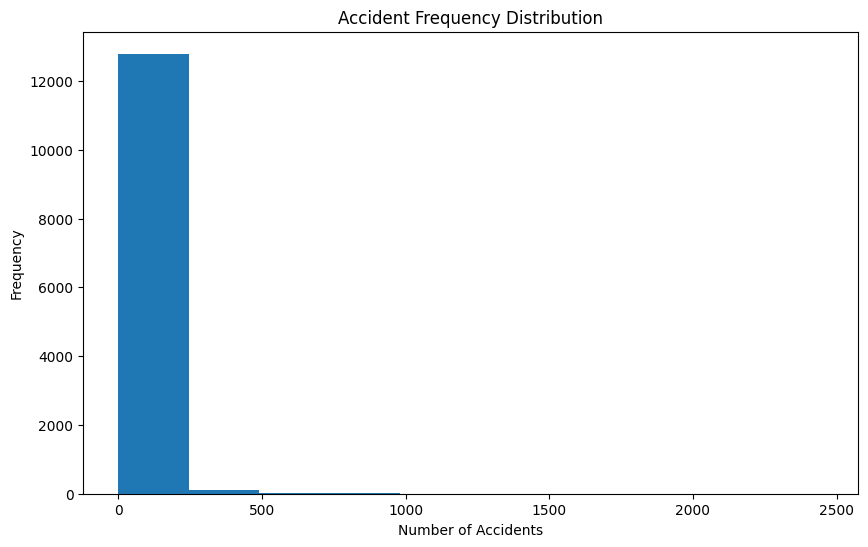

In [72]:
# Count the number of accidents for each mine
accident_counts = accidents_per_mine.iloc[:, 1:].count(axis=1)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(accident_counts, bins=10)  # Adjust the number of bins as needed

# Set labels and title
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.title('Accident Frequency Distribution')

# Show the plot
plt.show()

In [83]:
# Violation Occur Date is not always the same as Violation Issue Date - 
# Have to decide which one to use 
violations[violations['VIOLATION_ISSUE_DT'] != violations['VIOLATION_OCCUR_DT']][['VIOLATION_ISSUE_DT', 'VIOLATION_OCCUR_DT']]

,VIOLATION_ISSUE_DT,VIOLATION_OCCUR_DT
651127,03/24/2007,01/01/2003
15818,07/25/2005,01/01/2004
2751044,01/31/2005,01/01/2005
2343495,02/01/2006,01/01/2006
272994,02/01/2006,01/01/2006
...,...,...
1435444,05/02/2023,12/31/2022
1521989,03/08/2023,12/31/2022
1520310,03/09/2023,12/31/2022
1527594,03/22/2023,12/31/2022


In [82]:
# Sort Values by Violation Date
violations = violations.sort_values(by='VIOLATION_OCCUR_DT')

violations_per_mine = violations[['MINE_ID', 'VIOLATION_OCCUR_DT']]

# Create a new column 'VIOLATION' with unique violation numbers
violations_per_mine.loc[:, 'VIOLATION'] = 'VIOLATION_' + (violations_per_mine.groupby('MINE_ID').cumcount() + 1).astype(str)

# Pivot the DataFrame to reshape it with 'MINE_ID' as the index and 'VIOLATION' as the columns
violations_per_mine = violations_per_mine.pivot(index='MINE_ID', columns='VIOLATION', values='VIOLATION_OCCUR_DT')

# Rename the columns with the desired format
violations_per_mine.columns = ['VIOLATION_' + str(i) for i in range(1, len(violations_per_mine.columns) + 1)]

# Reset the index of the DataFrame
violations_per_mine = violations_per_mine.reset_index()

## Merge the Violations and the Accident dates into one dataframe

In [ ]:
merged_df = pd.merge(violations_per_mine, accidents_per_mine, on = 'MINE_ID')

In [ ]:
# Change date columns to date date types
date_columns = [col for col in merged_df.columns if col != 'MINE_ID']
merged_df[date_columns] = merged_df[date_columns].apply(pd.to_datetime)

# Verify the result
print(merged_df.dtypes)

MINE_ID                   int64
VIOLATION_1      datetime64[ns]
VIOLATION_2      datetime64[ns]
VIOLATION_3      datetime64[ns]
VIOLATION_4      datetime64[ns]
                      ...      
ACCIDENT_2450    datetime64[ns]
ACCIDENT_2451    datetime64[ns]
ACCIDENT_2452    datetime64[ns]
ACCIDENT_2453    datetime64[ns]
ACCIDENT_2454    datetime64[ns]
Length: 21064, dtype: object


filter it down for now for simplicity and to run faster 

In [ ]:
# Calculate the percentage of NA values for each column
na_percentages = merged_df.iloc[:, 1:].isnull().mean()

# # Get the columns with less than or equal to 50% NA values
columns_to_keep = na_percentages[na_percentages <= 0.30].index.tolist()

# # Select the columns to keep in merged_df
merged_df= merged_df[['MINE_ID'] + columns_to_keep]

In [ ]:
#merged_df = merged_df[['MINE_ID', 'VIOLATION_1', 'ACCIDENT_1']]

In [ ]:
# Find the last violation column
last_violation_col = merged_df.filter(regex='VIOLATION').columns[-1]
num_violation_cols = int(last_violation_col.split('_')[1])
print('There are', num_violation_cols, 'violation columns')

# Find the last accident column
last_accident_col = merged_df.filter(regex='ACCIDENT').columns[-1]
num_accident_cols = int(last_accident_col.split('_')[1])
print('There are', num_accident_cols, 'accident columns')

There are 17499 violation columns
There are 1112 accident columns


In [ ]:
merged_df.filter(regex = 'VIOLATION').columns

Index(['VIOLATION_1', 'VIOLATION_2', 'VIOLATION_1113', 'VIOLATION_2224',
       'VIOLATION_3335', 'VIOLATION_4446', 'VIOLATION_5557', 'VIOLATION_6668',
       'VIOLATION_7779', 'VIOLATION_8890', 'VIOLATION_9611', 'VIOLATION_9722',
       'VIOLATION_9723', 'VIOLATION_9834', 'VIOLATION_9945', 'VIOLATION_10056',
       'VIOLATION_10167', 'VIOLATION_10278', 'VIOLATION_10389',
       'VIOLATION_10500', 'VIOLATION_10611', 'VIOLATION_10722',
       'VIOLATION_10833', 'VIOLATION_10834', 'VIOLATION_10945',
       'VIOLATION_11056', 'VIOLATION_11167', 'VIOLATION_11278',
       'VIOLATION_11944', 'VIOLATION_13055', 'VIOLATION_14166',
       'VIOLATION_15277', 'VIOLATION_16388', 'VIOLATION_17499'],
      dtype='object')

In [ ]:
#merged_df = merged_df.drop(columns = ['VIOLATION_1_30'])

Create columns for each VIOLATION column that shows 30 days out from that violation 

In [ ]:
for i in range(1, num_violation_cols+1):  # Adjust the range based on the number of VIOLATION_i columns
    
    ## 30 days
    violation_col = f'VIOLATION_{i}'
    new_col = f'VIOLATION_{i}_30'

    if violation_col in merged_df.columns: 
        # Extract the VIOLATION_i column
        violation_dates = merged_df[violation_col]

        # Add 30 days to each date in the VIOLATION_i column
        violation_dates_30 = violation_dates + timedelta(days=30)

        # Add the new column to the DataFrame
        merged_df.insert(merged_df.columns.get_loc(violation_col) + 1, new_col, violation_dates_30)

    ## 60 days 
    violation_col = f'VIOLATION_{i}'
    new_col = f'VIOLATION_{i}_60'

    if violation_col in merged_df.columns: 
        # Extract the VIOLATION_i column
        violation_dates = merged_df[violation_col]

        # Add 60 days to each date in the VIOLATION_i column
        violation_dates_60 = violation_dates + timedelta(days=60)

        # Add the new column to the DataFrame
        merged_df.insert(merged_df.columns.get_loc(violation_col) + 1, new_col, violation_dates_60)

     
    ## 90 days
    violation_col = f'VIOLATION_{i}'
    new_col = f'VIOLATION_{i}_90'

    if violation_col in merged_df.columns:
        # Extract the VIOLATION_i column
        violation_dates = merged_df[violation_col]

        # Add 30 days to each date in the VIOLATION_i column
        violation_dates_90 = violation_dates + timedelta(days=90)

        # Add the new column to the DataFrame
        merged_df.insert(merged_df.columns.get_loc(violation_col) + 1, new_col, violation_dates_90)

In [ ]:
merged_df

,MINE_ID,VIOLATION_1,VIOLATION_1_90,VIOLATION_1_60,VIOLATION_1_30,VIOLATION_2,VIOLATION_2_90,VIOLATION_2_60,VIOLATION_2_30,VIOLATION_1113,...,VIOLATION_16388,VIOLATION_16388_90,VIOLATION_16388_60,VIOLATION_16388_30,VIOLATION_17499,VIOLATION_17499_90,VIOLATION_17499_60,VIOLATION_17499_30,ACCIDENT_1,ACCIDENT_1112
0,100003,2002-01-02,2002-04-02,2002-03-03,2002-02-01,2000-01-04,2000-04-03,2000-03-04,2000-02-03,2000-01-04,...,2013-01-03,2013-04-03,2013-03-04,2013-02-02,2000-01-04,2000-04-03,2000-03-04,2000-02-03,2007-01-08,2005-01-14
1,100004,2013-01-02,2013-04-02,2013-03-03,2013-02-01,2013-01-03,2013-04-03,2013-03-04,2013-02-02,2013-01-03,...,2013-01-03,2013-04-03,2013-03-04,2013-02-02,2013-01-03,2013-04-03,2013-03-04,2013-02-02,2008-01-07,2010-01-09
2,100006,2016-01-27,2016-04-26,2016-03-27,2016-02-26,2008-04-14,2008-07-13,2008-06-13,2008-05-14,2015-04-14,...,2010-03-09,2010-06-07,2010-05-08,2010-04-08,2006-04-11,2006-07-10,2006-06-10,2006-05-11,2000-01-13,2015-02-08
3,100008,2019-01-10,2019-04-10,2019-03-11,2019-02-09,2016-02-02,2016-05-02,2016-04-02,2016-03-03,2016-02-02,...,2013-01-22,2013-04-22,2013-03-23,2013-02-21,2013-01-30,2013-04-30,2013-03-31,2013-03-01,2015-01-06,2015-01-07
4,100009,2007-01-03,2007-04-03,2007-03-04,2007-02-02,2011-01-13,2011-04-13,2011-03-14,2011-02-12,2013-01-16,...,2013-01-10,2013-04-10,2013-03-11,2013-02-09,2013-01-10,2013-04-10,2013-03-11,2013-02-09,2023-02-21,2007-03-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12807,5400493,2023-01-12,2023-04-12,2023-03-13,2023-02-11,2023-02-10,2023-05-11,2023-04-11,2023-03-12,2016-02-18,...,2020-01-22,2020-04-21,2020-03-22,2020-02-21,2020-01-22,2020-04-21,2020-03-22,2020-02-21,2022-09-14,NaT
12808,5400500,2022-02-07,2022-05-08,2022-04-08,2022-03-09,2019-06-18,2019-09-16,2019-08-17,2019-07-18,2019-06-18,...,2019-06-18,2019-09-16,2019-08-17,2019-07-18,2019-06-18,2019-09-16,2019-08-17,2019-07-18,2022-02-02,NaT
12809,5500002,2000-01-13,2000-04-12,2000-03-13,2000-02-12,2012-01-30,2012-04-29,2012-03-30,2012-02-29,2012-01-30,...,2016-01-27,2016-04-26,2016-03-27,2016-02-26,2016-01-27,2016-04-26,2016-03-27,2016-02-26,2019-01-03,2016-01-13
12810,5500005,2000-01-11,2000-04-10,2000-03-11,2000-02-10,2000-10-19,2001-01-17,2000-12-18,2000-11-18,NaT,...,2000-10-17,2001-01-15,2000-12-16,2000-11-16,2000-10-18,2001-01-16,2000-12-17,2000-11-17,2001-01-09,2001-01-22


Add column to count how many accidents have occured in the 30 days since that accident

In [ ]:
# Extract the violation columns into a separate DataFrame
violation_df = merged_df.filter(regex='^VIOLATION')

# Select the accident columns
accident_df = merged_df.filter(regex='^ACCIDENT')

# Initialize an empty DataFrame to store the count of accidents
accidents_after_violation_df = pd.DataFrame(index=merged_df.index)

# Iterate over each violation column
for i in range(1, num_violation_cols + 1):

    violation_col = f'VIOLATION_{i}'
    violation_30_col = f'VIOLATION_{i}_30'
    
    if violation_col and violation_30_col in merged_df.columns: 

        # Create a mask to filter the accidents columns within the range of violation dates
        mask = (accident_df >= violation_df[violation_col].values[:, np.newaxis]) & (accident_df <= violation_df[violation_30_col].values[:, np.newaxis])

        # Count the number of accidents within the range for each row
        count_accidents = mask.sum(axis=1)

        # Add the count as a new column to the accidents_after_violation_df DataFrame
        column_name = f'ACCIDENTS_AFTER_VIOLATION_{i}'
        accidents_after_violation_df[column_name] = count_accidents

# Concatenate the accidents_after_violation_df DataFrame with the merged_df DataFrame
merged_df = pd.concat([merged_df, accidents_after_violation_df], axis=1)

In [ ]:
merged_df.filter(regex = 'ACCIDENTS_AFTER_VIOLATION_1').columns

Index(['ACCIDENTS_AFTER_VIOLATION_1', 'ACCIDENTS_AFTER_VIOLATION_1113',
       'ACCIDENTS_AFTER_VIOLATION_10056', 'ACCIDENTS_AFTER_VIOLATION_10167',
       'ACCIDENTS_AFTER_VIOLATION_10278', 'ACCIDENTS_AFTER_VIOLATION_10389',
       'ACCIDENTS_AFTER_VIOLATION_10500', 'ACCIDENTS_AFTER_VIOLATION_10611',
       'ACCIDENTS_AFTER_VIOLATION_10722', 'ACCIDENTS_AFTER_VIOLATION_10833',
       'ACCIDENTS_AFTER_VIOLATION_10834', 'ACCIDENTS_AFTER_VIOLATION_10945',
       'ACCIDENTS_AFTER_VIOLATION_11056', 'ACCIDENTS_AFTER_VIOLATION_11167',
       'ACCIDENTS_AFTER_VIOLATION_11278', 'ACCIDENTS_AFTER_VIOLATION_11944',
       'ACCIDENTS_AFTER_VIOLATION_13055', 'ACCIDENTS_AFTER_VIOLATION_14166',
       'ACCIDENTS_AFTER_VIOLATION_15277', 'ACCIDENTS_AFTER_VIOLATION_16388',
       'ACCIDENTS_AFTER_VIOLATION_17499'],
      dtype='object')

Merge the Violations and the Accident dates into one dataframe

In [89]:
merged_df = pd.merge(violations_per_mine, accidents_per_mine, on = 'MINE_ID')

In [119]:
# Calculate the percentage of NA values for each column
na_percentages = merged_df.iloc[:, 1:].isnull().mean()

# # Get the columns with less than or equal to 50% NA values
columns_to_keep = na_percentages[na_percentages <= 0.5].index.tolist()

# # Select the columns to keep in merged_df
merged_df_filtered = merged_df[['MINE_ID'] + columns_to_keep]


In [123]:
merged_df = merged_df[['MINE_ID', 'VIOLATION_1', 'ACCIDENT_1']]

In [128]:
# Convert 'ACCIDENT_DT' column in accidents DataFrame to datetime format
accidents['ACCIDENT_DT'] = pd.to_datetime(accidents['ACCIDENT_DT'], format='%m/%d/%Y')

# Define time intervals
time_intervals = [30, 60, 90]

# Create a new DataFrame to store the results
result_df = pd.DataFrame({'MINE_ID': merged_df['MINE_ID']})

# Iterate over each violation column
for col in merged_df.columns[1:]:
    # Extract the violation dates for the column and drop NA values
    violation_dates = merged_df[col].dropna()
    
    # Create a DataFrame to store the results for the current violation column
    violation_result_df = pd.DataFrame({'MINE_ID': merged_df['MINE_ID'], col: violation_dates})
    
    # Calculate date ranges for each time interval
    start_dates = [pd.to_datetime(violation_dates, format='%m/%d/%Y') + pd.DateOffset(days=interval) for interval in time_intervals]
    end_dates = [start_date + pd.DateOffset(days=1) for start_date in start_dates]
    
    # Check if an accident occurred within each time interval
    accidents_within_intervals = pd.merge(violation_result_df[['MINE_ID']], accidents, on='MINE_ID')
    accidents_within_intervals = accidents_within_intervals[(accidents_within_intervals['ACCIDENT_DT'].values[:, None] >= start_dates[0].values) & (accidents_within_intervals['ACCIDENT_DT'].values[:, None] < end_dates[0].values)]
    
    # Reshape the result to a 2D array
    result = np.zeros((len(violation_result_df), len(time_intervals)))
    
    # Determine which intervals have accidents
    for i, interval in enumerate(time_intervals):
        has_accident = np.isin(violation_result_df['MINE_ID'].values, accidents_within_intervals.loc[(accidents_within_intervals['ACCIDENT_DT'] >= start_dates[i].iloc[:, 0]) & (accidents_within_intervals['ACCIDENT_DT'] < end_dates[i].iloc[:, 0]), 'MINE_ID'].values)
        result[:, i] = has_accident.astype(int)
    
    # Add binary columns indicating if an accident occurred
    violation_result_df[[f'{col}_{interval}' for interval in time_intervals]] = result
    
    # Merge the results for the current violation column into the main result DataFrame
    result_df = pd.merge(result_df, violation_result_df, on='MINE_ID')

# Sort the result DataFrame by MINE_ID
result_df = result_df.sort_values(by='MINE_ID')

# Reset the index of the DataFrame
result_df = result_df.reset_index(drop=True)

IndexingError: Too many indexers

# Train Test Split